In [1]:
%matplotlib inline
import sys
sys.path.insert(0, 'src')

In [2]:
import stlcg
import stlviz as viz
from stlcg import Expression
from utils import print_learning_progress

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

## Create traces from numpy arrays

In [4]:
t = t = np.arange(-3, 3, 0.2, dtype=np.float32)
x_np = 0.5 * np.exp(-t**2).reshape([1, t.shape[0], 1])
w_np = (0.4*np.exp(-(t + 0.5)**2) + 0.2*np.exp(-(t - 3)**2)).reshape([1, t.shape[0], 1])

x = torch.tensor(x_np, requires_grad=False)
w = torch.tensor(w_np, requires_grad=False)
c = torch.tensor(1.0, dtype=torch.float, requires_grad=True)
d = torch.tensor(0.9, dtype=torch.float, requires_grad=True)

Text(0.5, 1.0, 'Traces')

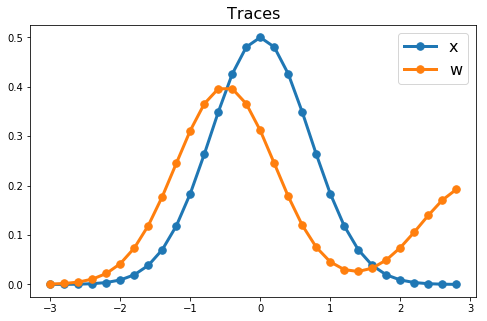

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(t, x_np[0,:,0], ".-", linewidth=3, markersize=15, label="x")
plt.plot(t, w_np[0,:,0], ".-", linewidth=3, markersize=15, label="w")
plt.legend(fontsize=16)
plt.title("Traces", fontsize=16)

# Constructing STL formulas

### One way to construct formulas is to explicitly call the constructors

(◻ [0, inf]( x <= 1.0 )) ∧ (◻ [0, inf]( w <= 0.9 ))


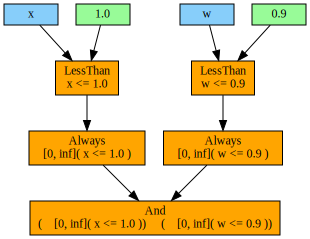

In [6]:
ϕ1 = stlcg.LessThan(lhs='x', val=c)
ϕ2 = stlcg.GreaterThan(lhs='w', val=d)
ϕ3 = stlcg.LessThan(lhs='w', val=d)
ϕ = stlcg.Always(subformula=ϕ1)
ψ = stlcg.Always(subformula=ϕ3)
formula = stlcg.And(subformula1=ϕ, subformula2=ψ)
print(formula)
viz.make_stl_graph(formula)

### Another way (preferred way) is to use the math operators which have been overloaded
#### (less than, greater than, equal, not, and, or)
#### Still need to use the Always and Or constructors explicitly

In [7]:
x_exp = Expression('x', x)    # The first argument is the name of the variable, the second argument is the numerical value
w_exp = Expression('w', w)
c_exp = Expression('c', c)         # If the variable is a parameter of the STL, then input the actual value
d_exp = Expression('d', d)

(◻ [0, inf]( x <= c )) ∧ (◻ [0, inf]( w <= d ))


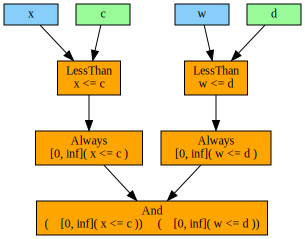

In [8]:
ϕ1 = x_exp <= c_exp
ϕ2 = w_exp >= d_exp 
ϕ3 = w_exp <= d_exp
ϕ = stlcg.Always(subformula=ϕ1)
ψ = stlcg.Always(subformula=ϕ3)
formula = stlcg.And(subformula1=ϕ, subformula2=ψ)
print(formula)
viz.make_stl_graph(formula)

## Evaluating the formula
### You need to feed in the necessary inputs. If the formula requires multiple inputs, it takes in a tuple of length 2 where each element in the tuple is the input to each subformula, in the order they are created. If the formula requires more than two inputs, then the tuple contains a tuple, eg. (x, (y, z)). The grouping of the input traces depend on how the formula was created.

#### the inputs can be made up of tensors, or Expression objects.

(w >= d) ∧ ((◻ [0, inf]( x <= c )) ∧ (◻ [0, inf]( w <= d )))


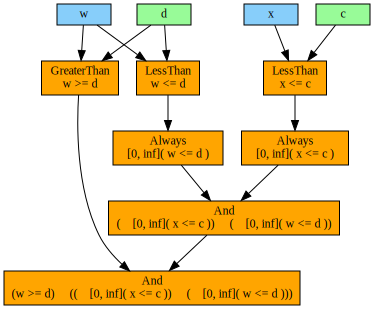

In [9]:
formula2 = ϕ2 & formula
print(formula2)
viz.make_stl_graph(formula2)

In [10]:
# any of the inputs will work
inputs = (w, (x_exp, w_exp))
# inputs = (w_exp, (x_exp, w_exp))
# inputs = (w, (x, w))

pscale = 1     # "pscale" is the scale used for evaluting predicates
scale = -1     # "scale" is the scale used in the maxish/minish function. <0 defaults to the true min/max
formula2(inputs, pscale=pscale, scale=scale)

tensor([[[-0.8992],
         [-0.8980],
         [-0.8951],
         [-0.8892],
         [-0.8778],
         [-0.8578],
         [-0.8262],
         [-0.7807],
         [-0.7221],
         [-0.6549],
         [-0.5885],
         [-0.5344],
         [-0.5040],
         [-0.5040],
         [-0.5344],
         [-0.5885],
         [-0.6549],
         [-0.7218],
         [-0.7801],
         [-0.8246],
         [-0.8542],
         [-0.8699],
         [-0.8737],
         [-0.8670],
         [-0.8506],
         [-0.8257],
         [-0.7943],
         [-0.7604],
         [-0.7295],
         [-0.7078]]], grad_fn=<MinBackward0>)

# Testing grad functionality

◻ [0, inf]( x <= c )


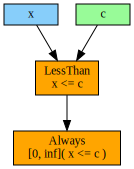

In [11]:
x_exp = Expression('x', x)
w_exp = Expression('w', w)
c_exp = Expression('c', c)
d_exp = Expression('d', d)
lt = x_exp <= c_exp
gt = w_exp <= d_exp
formula = stlcg.Always(subformula=lt)
inputs = x
var_dict = {'c': c}
print(formula)
viz.make_stl_graph(formula)

In [12]:
learning_rate = 0.05
device = torch.device("cpu")
optimizer = torch.optim.Adam(var_dict.values(), lr=learning_rate)
scale = 0.5


In [18]:

for i in range(20000):
    sc = scale + i/500
    loss = formula.robustness(inputs, scale=sc).mean()**2 #+ 0.001*(c**2 + d**2)
    if i % 500 == 0:
        print_learning_progress(formula, inputs, var_dict, i, loss, sc)
    loss.backward()
    with torch.no_grad():
        c -= learning_rate * c.grad
        c.grad.zero_()
#         d -= learning_rate * d.grad
#         d.grad.zero_()

iteration: 0 -- loss: 36.224 ---- c:1.000 ---- scale:0.500 ---- true value:0.500
iteration: 500 -- loss: 0.001 ---- c:2.488 ---- scale:1.500 ---- true value:1.988
iteration: 1000 -- loss: 0.000 ---- c:1.569 ---- scale:2.500 ---- true value:1.069
iteration: 1500 -- loss: 0.000 ---- c:1.190 ---- scale:3.500 ---- true value:0.690
iteration: 2000 -- loss: 0.000 ---- c:0.988 ---- scale:4.500 ---- true value:0.488
iteration: 2500 -- loss: 0.000 ---- c:0.866 ---- scale:5.500 ---- true value:0.366
iteration: 3000 -- loss: 0.000 ---- c:0.787 ---- scale:6.500 ---- true value:0.287
iteration: 3500 -- loss: 0.000 ---- c:0.732 ---- scale:7.500 ---- true value:0.232
iteration: 4000 -- loss: 0.000 ---- c:0.692 ---- scale:8.500 ---- true value:0.192
iteration: 4500 -- loss: 0.000 ---- c:0.663 ---- scale:9.500 ---- true value:0.163
iteration: 5000 -- loss: 0.000 ---- c:0.640 ---- scale:10.500 ---- true value:0.140
iteration: 5500 -- loss: 0.000 ---- c:0.623 ---- scale:11.500 ---- true value:0.123
itera

In [14]:
c

tensor(0.5172, requires_grad=True)